In [ ]:
import pandas as pd
import os, gc, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import roc_curve,auc, precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score


sys.path.append("../source/")
from data_loader import *


In [2]:
useID = True

dl = DataLoader()
df = dl.load_csv("train_transaction.csv", "train_identity.csv")

# if useID:
#     dl.transaction = False
#     df_id = dl.load_csv("train_identity.csv")

#     df = df_tr.merge(df_id, how='left', left_index=True, right_index=True)

#     del df_id, df_tr #, df_tr_test

# else:
#     df = df_tr
#     #df_test = df_tr_test
#     del df_tr#, df_tr_test


# df_train['isTrain'] = 1
# df_test['isTrain'] = 0

# df = pd.concat([df_train, df_test])
gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float32(376), int16(1), int32(2), int8(1), object(14)
memory usage: 1.2 GB
Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)
done
uid
what
['TransactionAmt', 'TransactionDT', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'DeviceType', 'DeviceInfo', 'D1n']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 484 entries, TransactionID to R_emaildomain_FE
dtypes: bool(9), float32(462), float64(2), int16(1), int32(2), int8(7), object(1)
memory usage: 1.1 GB


20

In [ ]:
# total_dropped_columns = []

# v_columns = [v for v in df.columns if v.startswith("V")]
# to_drop = remove_correlated_columns(df, v_columns)
# df = df.drop(columns=list(to_drop))
# total_dropped_columns += to_drop

# d_columns = [v for v in df.columns if v.startswith("D")]
# if "D1" in d_columns:
#     d_columns.remove("D1")
# to_drop = remove_correlated_columns(df, d_columns)
# df = df.drop(columns=list(to_drop))
# total_dropped_columns += to_drop

# with open("drop_columns.txt", "w") as f:
#     for item in total_dropped_columns:
#         f.write(item + "\n")


In [16]:
df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15_uid_std,DeviceType_uid_std,DeviceInfo_uid_std,D1n_uid_std,addr1_FE,card1_FE,card2_FE,card3_FE,P_emaildomain_FE,R_emaildomain_FE
0,2987000,0,86400,68.500000,0,13926,NaN,150.0,0,142.0,...,NaN,NaN,NaN,NaN,0.043972,0.000073,NaN,0.885075,0.159949,0.767516
1,2987001,0,86401,29.000000,0,2755,404.0,150.0,1,102.0,...,NaN,NaN,NaN,NaN,0.081456,0.001157,0.005254,0.885075,0.386688,0.767516
2,2987002,0,86469,59.000000,0,4663,490.0,150.0,2,166.0,...,71.714134,NaN,NaN,0.0,0.050086,0.001876,0.065586,0.885075,0.008629,0.767516
3,2987003,0,86499,50.000000,0,18132,567.0,150.0,1,117.0,...,18.858822,NaN,NaN,0.0,0.018059,0.007127,0.010552,0.885075,0.170918,0.767516
4,2987004,0,86506,50.000000,1,4497,514.0,150.0,1,102.0,...,NaN,NaN,NaN,NaN,0.006823,0.000030,0.025001,0.885075,0.386688,0.767516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,0,6550,NaN,150.0,2,226.0,...,20.506096,NaN,NaN,0.0,0.038376,0.002003,NaN,0.885075,0.159949,0.767516
590536,3577536,0,15811049,39.500000,0,10444,225.0,150.0,1,224.0,...,NaN,NaN,NaN,NaN,0.080063,0.000020,0.012801,0.885075,0.386688,0.767516
590537,3577537,0,15811079,30.950001,0,12037,595.0,150.0,1,224.0,...,NaN,NaN,NaN,NaN,0.014490,0.001168,0.001262,0.885075,0.386688,0.767516
590538,3577538,0,15811088,117.000000,0,7826,481.0,150.0,1,224.0,...,8.755678,NaN,NaN,0.0,0.015599,0.005090,0.010894,0.885075,0.047904,0.767516


In [6]:
with open("drop_columns.txt") as f:
    to_drop = f.readlines()

to_drop = [item.strip() for item in to_drop]
df = df.drop(columns=to_drop)

In [ ]:
# for uid in df['uid'].values:
#     if len(df[df['uid']==uid]) > 1:
#         if  df[df['uid']==uid].iloc[0]['isFraud'] == 1:
#             d = df[df['uid']==uid]
#         break

In [ ]:
# df[df['uid']=='10011_476.0_50.0']

In [ ]:
# d = df[df['uid']=='12695_325.0_0.0']
# d = d.sort_values(by="TransactionDT")
# consecutive_fraud = 0
# for i in range(len(d)):
#     if d.iloc[i]['isFraud'] == 1:
#         consecutive_fraud += 1
#     else:
#         print(consecutive_fraud)

In [ ]:
# # Fill NaN for V columns with mean values
# v_columns = [str(col) for col in df.columns if str(col).startswith("V")]
# df = df.fillna(df[v_columns].mean())


In [7]:
from sklearn.model_selection import train_test_split
y = df["isFraud"]
X = df.drop(columns=["isFraud", "uid", "card1", "addr1", "D1", "TransactionID", "D1n"])
# X = df.drop(columns=["isFraud", "uid", "TransactionID"])
# X = X[top_features['feature'].values]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120, stratify=y)


In [8]:
params = {"device":"cuda", "objective":"binary:logistic",
                "eval_metric":"aucpr", #logloss
                'learning_rate': 0.1,
                'max_depth': 12, }

dtrain = xgb.DMatrix(X_train, label=y_train) 
dval = xgb.DMatrix(X_test, label=y_test)

model = xgb.train(params, dtrain, num_boost_round=150)
importance = model.get_score(importance_type='weight')

model.save_model("model.json")
y_prob = model.predict(dval)

del dtrain, dval, X_train, y_train, X_test


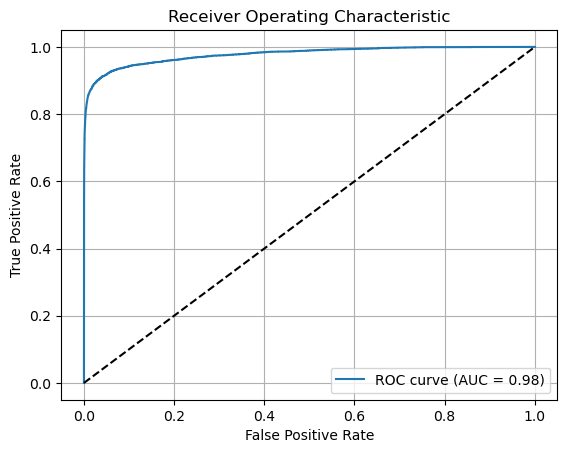

In [9]:
 
# Compute ROC curve and AUC
fpr, tpr, threshold = roc_curve(y_test.astype(int).values, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Best F1: 0.8435 at threshold: 0.1963
auc 0.8871871481684559


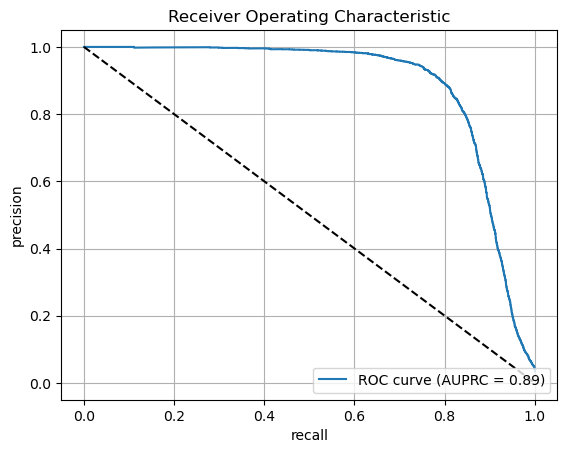

In [10]:
 
# Compute ROC curve and AUC
precision, recall, threshold = precision_recall_curve(y_test.astype(int).values, y_prob)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]

best_index = np.argmax(f1_scores)
best_threshold = threshold[best_index]

roc_auc = auc(recall, precision)
print(f"Best F1: {f1_scores[best_index]:.4f} at threshold: {best_threshold:.4f}")
print("auc", roc_auc)
plt.figure()
plt.plot(recall,precision, label=f'ROC curve (AUPRC = {roc_auc:.2f})')
plt.plot([0, 1], [1, 0], 'k--')  # Diagonal line
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

y_pred = y_prob > best_threshold
y_pred = (y_pred == 1).astype(int)


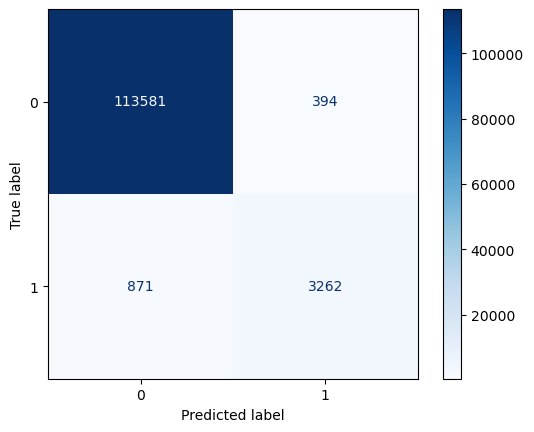

In [8]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

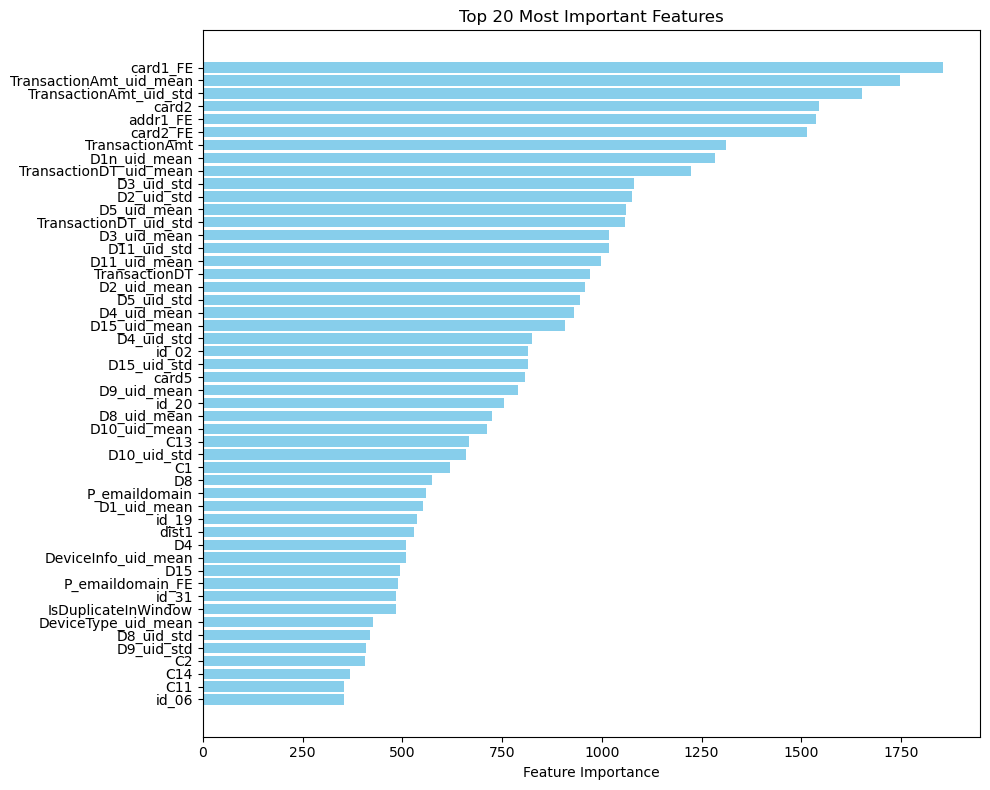

In [11]:
# Convert to DataFrame for easier handling
importances_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})

# Sort by importance and take top 20
top_features = importances_df.sort_values(by='importance', ascending=False).head(50)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel(f'Feature Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

In [ ]:
top_features.to_csv("top_features_agekow.csv", index=False)

In [ ]:
# # Isolation doesn't work, because individual instances are not isFraud! 
# # we need to try to group uinque cards together and make aggregate features
# # Then predict which cards are outliers


# clf = IsolationForest().fit(X)
# pred = clf.predict(X_test)

In [ ]:
# pred = (pred == -1).astype(int) # -1 is an outlier, but in our data 1 == isFraud


In [ ]:
# cm = confusion_matrix(y_test, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
# disp.plot(cmap='Blues')

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test, pred)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()